<a href="https://colab.research.google.com/github/Liranbz/Deep-Learning-workshop/blob/master/nn_1_binary_fixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eyaler/workshop/blob/master/nn_1_binary.ipynb)

# 1. Neural networks and back propagation for binary classification

In [0]:
# import required packages
import numpy as np #for matrics
import matplotlib #for plots
import matplotlib.pyplot as plt #same
from sklearn.datasets import make_moons #for datasets
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

In [0]:
# create data
XX, YY = make_moons(n_samples=1000, noise=.2, random_state=41)
with open('ex1.csv','w') as f:
    f.writelines('%f,%f,%f\n'%(x[0],x[1],y) for x,y in zip (XX,YY))

In [0]:
# load data
data = np.genfromtxt('ex1.csv', delimiter=',')
num_examples = len(data)
print(num_examples)

1000


In [0]:
# randomize data and split to train and test
np.random.seed(42)
np.random.shuffle(data)

split = int(num_examples*0.8)
train = data[:split]
test = data[split:]
print(train.shape, test.shape)
print(train[:5])

(800, 3) (200, 3)
[[-0.25666   0.941459  0.      ]
 [ 1.673439 -0.476619  1.      ]
 [ 0.964778  0.428332  0.      ]
 [ 1.181203  0.060972  0.      ]
 [ 1.487823 -0.693376  1.      ]]


(800, 2) (200, 2)
(800,) (200,)


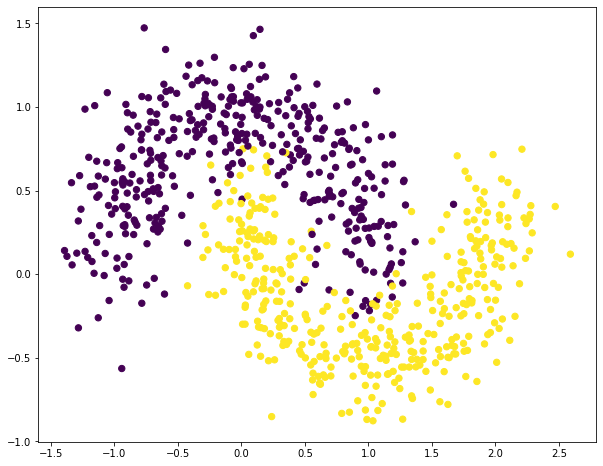

In [0]:
# get features and labels
X_train, y_train = train[:,:2], train[:,2]
X_test, y_test = test[:,:2], test[:,2]

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

# visulize the training set
plt.scatter(X_train[:,0], X_train[:,1], s=40, c=y_train)

In [0]:
#setup weight martices and initialize
def init_weights(num_input_nodes, num_output_nodes):
    return np.random.uniform(low=-1, high=1, size=(num_input_nodes, num_output_nodes))

In [0]:
#implement sigmoid function
def sigmoid(z):
    ret=1/(1+np.exp(-z))
    
    return ret

In [0]:
#implement cross entropy
def cross_entropy(H, y):
    ret=-y*np.log(H+1e-7)-(1-y)*np.log(1-H+1e-7)
    
    return ret

In [0]:
def correct(H, y):
    ret=y if H>0.5 else 1-y
    
    return ret

In [0]:
#implement layer - compute values at output of layer (after sigmoid activation)
def compute_layer(inputs_to_layer, weights):
    ret = sigmoid(weights.T@inputs_to_layer)
    
    return ret

In [0]:
def forward_pass(x, w, m):
    x = np.expand_dims(x, axis=-1)
    h = compute_layer(x, w)
    h = np.vstack((np.ones((1,1)), h)) # added a constant hidden node for bias calculations
    H = compute_layer(h, m)[0,0]
    return x,h,H

In [0]:
def backward_pass(x, h, H, y, m):
    djdm = (H-y)*h
    djdw = (djdm*m*(1-h))[1:].T*x # 1: to ignore bias term
    return djdm, djdw

In [0]:
def train(features, labels, num_epochs, num_hidden_nodes, learning_rate):
    features = np.hstack((np.ones((len(features),1)), features)) # added a constant input node for bias calculations
    num_examples, num_features = features.shape
    w = init_weights(num_features, num_hidden_nodes)
    m = init_weights(num_hidden_nodes+1, 1) # +1 to allow bias calculations
    for i in range(num_epochs):
        loss = 0
        acc = 0
        sum_djdm = 0
        sum_djdw = 0
        for x, y in zip(features, labels):
            x, h, H = forward_pass(x, w, m)
            loss += cross_entropy(H, y)
            acc += correct(H, y)
            djdm, djdw = backward_pass(x, h, H, y, m)
            sum_djdm += djdm
            sum_djdw += djdw
        m -= learning_rate*sum_djdm/num_examples
        w -= learning_rate*sum_djdw/num_examples
        if (i+1)%100==0:
            print(i+1, loss/num_examples, acc/num_examples)
    return w, m

In [0]:
def test(features, labels, w, m):
    features = np.hstack((np.ones((len(features),1)), features)) # added a constant input node for bias calculations
    num_examples, num_features = features.shape
    loss = 0
    acc = 0
    for x, y in zip(features, labels):
        x, h, H = forward_pass(x, w, m)
        loss += cross_entropy(H, y)
        acc += correct(H, y)
    return loss/num_examples, acc/num_examples

In [0]:
def predict(features, w, m):
    features = np.hstack((np.ones((len(features),1)), features)) # added a constant input node for bias calculations
    pred = []
    for x in features:
        x, h, H = forward_pass(x, w, m)
        pred.append(1 if H>=0.5 else 0)
    return np.array(pred)
    

In [0]:
def get_probs(features, w, m):
    features = np.hstack((np.ones((len(features),1)), features)) # added a constant input node for bias calculations
    prob = []
    for x in features:
        x, h, H = forward_pass(x, w, m)
        prob.append(H)
    return np.array(prob)

In [0]:
# Decision boundary visualization

def plot_decision_boundary(features, labels, w, m):
    # Set min and max values and give it some padding
    x_min, x_max = features[:, 0].min() - .5, features[:, 0].max() + .5
    y_min, y_max = features[:, 1].min() - .5, features[:, 1].max() + .5
    
    # Generate a grid of points with distance h between them
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), 
                         np.arange(y_min, y_max, h))
    
    # Predict the function value for the whole grid
    g = predict(np.c_[xx.ravel(), yy.ravel()], w, m)
    g = g.reshape(xx.shape)
    
    # Plot the contour and test examples
    plt.contourf(xx, yy, g, cmap=plt.cm.Spectral)
    plt.scatter(features[:, 0], features[:, 1], s=40, c=labels)

100 0.7001204803817619 0.4425
200 0.6449215684794624 0.845
300 0.5487294731867237 0.835

test: 0.5394448829293961 0.875


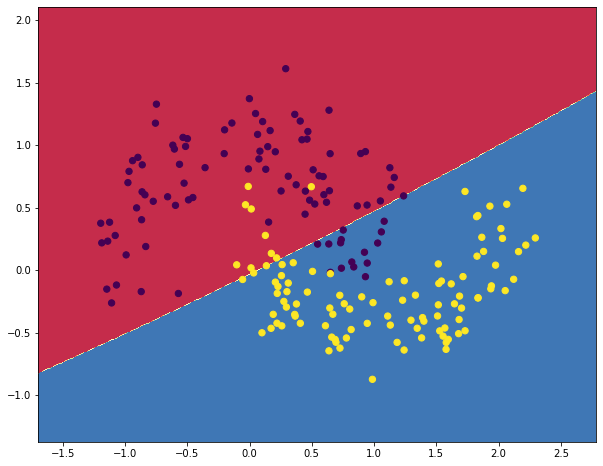

In [0]:
#EX: what do you think about the following results?
w,m = train(X_train, y_train, num_epochs=300, num_hidden_nodes=2, learning_rate=0.1)
loss,acc = test(X_test, y_test, w, m)
print ('\ntest:',loss,acc)
plot_decision_boundary(X_test, y_test, w, m)

100 0.2543806165634449 0.895
200 0.10402319357317381 0.96375
300 0.09082556725471261 0.96625
400 0.08736137869895196 0.9675
500 0.08584151882888708 0.9675
600 0.0849287188276684 0.96625
700 0.08426522063170394 0.9675

test: 0.08450006385426453 0.965


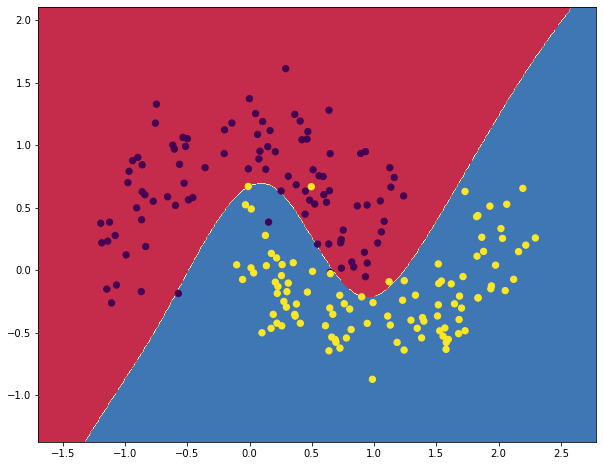

In [0]:
#EX: find a setting of epochs, hidden units and learning rates with better results. how do these parameters affect the results?
w,m = train(X_train, y_train, num_epochs=750, num_hidden_nodes=10, learning_rate=10)
loss,acc = test(X_test, y_test, w, m)
print ('\ntest:',loss,acc)
plot_decision_boundary(X_test, y_test, w, m)

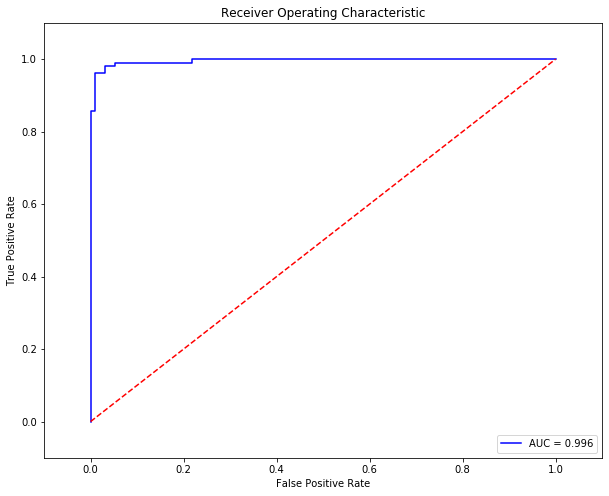

In [0]:
#ROC and AUC
from sklearn.metrics import roc_curve, auc
# calculate the fpr and tpr for all thresholds of the classification
probs = get_probs(X_test, w, m)
fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()